In [55]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [56]:
import logging
import string
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from replay_trajectory_classification import ClusterlessClassifier

from src.figure_utilities import set_figure_defaults
from src.parameters import TRANSITION_TO_CATEGORY

set_figure_defaults()

## Examples

In [3]:
import copy

from src.load_data import load_data
from src.parameters import (
    ANIMALS,
    PROBABILITY_THRESHOLD,
    PROCESSED_DATA_DIR,
    SAMPLING_FREQUENCY,
    TRANSITION_TO_CATEGORY,
    continuous_transition_types,
    discrete_diag,
    model,
    model_kwargs,
    movement_var,
    place_bin_size,
    replay_speed,
)
from loren_frank_data_processing import (
    get_multiunit_dataframe,
    get_multiunit_dataframe2,
)
from loren_frank_data_processing.position import (
    make_track_graph,
    EDGE_ORDER,
    EDGE_SPACING,
)
from src.figure3 import plot_clusterless_1D_results, plot_1D_projected_to_2D


def plot_ripple_figure_1D(
    epoch_key, ripple_numbers, is_save_figure=True, cmap="bone_r"
):
    if isinstance(ripple_numbers, int):
        ripple_numbers = [ripple_numbers]
    data_type, dim = "clusterless", "1D"
    animal, day, epoch = epoch_key
    data = load_data(epoch_key)

    multiunit_times = [
        get_multiunit_dataframe(tetrode_key, ANIMALS)
        for tetrode_key in data["tetrode_info"].index
    ]
    if multiunit_times[0] is None:
        multiunit_times = [
            get_multiunit_dataframe2(tetrode_key, ANIMALS)
            for tetrode_key in data["tetrode_info"].index
        ]

    # Fit
    is_training = data["position_info"].speed > 4
    position = data["position_info"].loc[:, "linear_position"]
    track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

    model_name = os.path.join(
        PROCESSED_DATA_DIR, f"{animal}_{day:02}_{epoch:02}_{data_type}_{dim}_model.pkl"
    )
    classifier = ClusterlessClassifier.load_model(model_name)

    results = xr.open_dataset(
        os.path.join(PROCESSED_DATA_DIR, f"{animal}_{day:02d}_{epoch:02d}.nc"),
        group=f"/{data_type}/{dim}/classifier/ripples/",
    )

    for ripple_number in ripple_numbers:
        plot_clusterless_1D_results(
            multiunit_times,
            data,
            results.sel(ripple_number=ripple_number).dropna("time", how="all"),
            classifier,
            epoch_key,
            ripple_number,
            cmap=cmap,
            is_save_figure=is_save_figure,
        )

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules


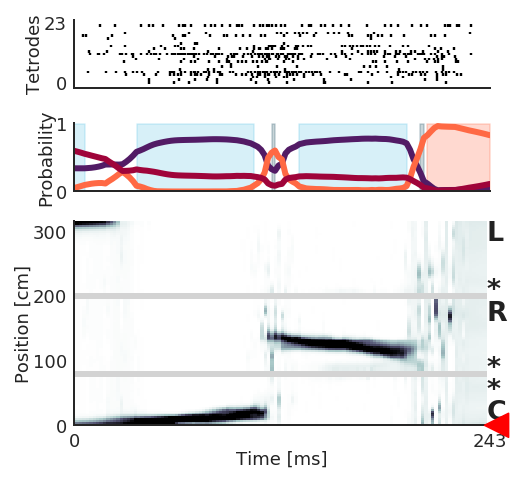

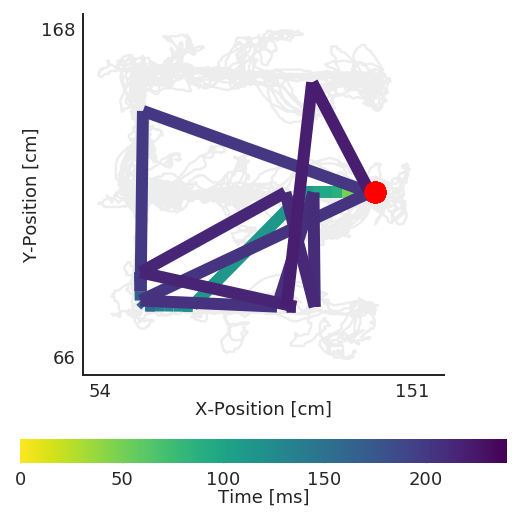

In [8]:
epoch_key = "bon", 3, 6
ripple_number = 181

plot_ripple_figure_1D(epoch_key, ripple_number)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO37.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO37.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO37.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO37.mat
No DIO file found, inferring correct inbound/outbound from task rules


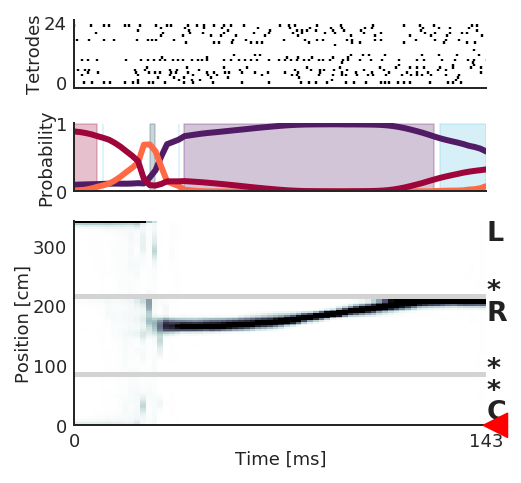

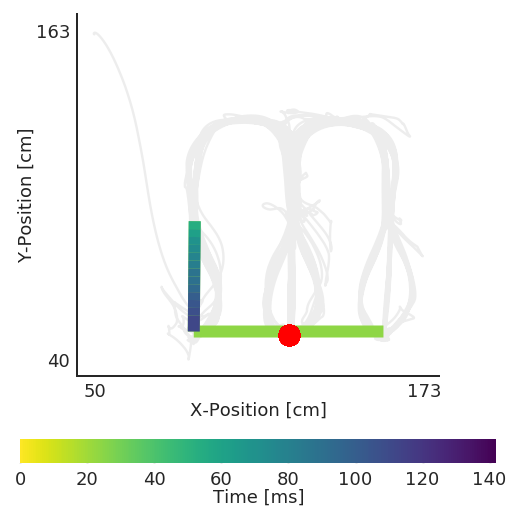

In [5]:
epoch_key = "remy", 37, 4
ripple_number = 50

plot_ripple_figure_1D(epoch_key, ripple_number)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules


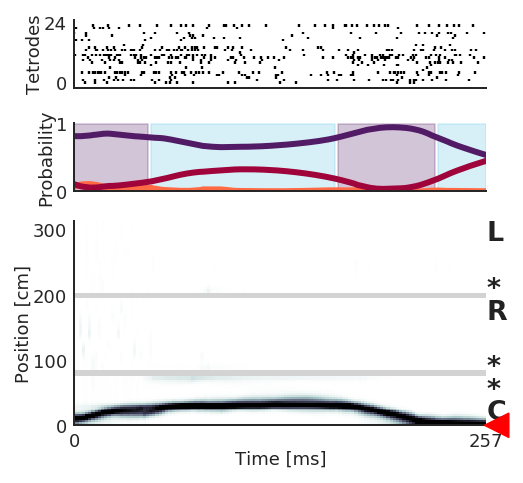

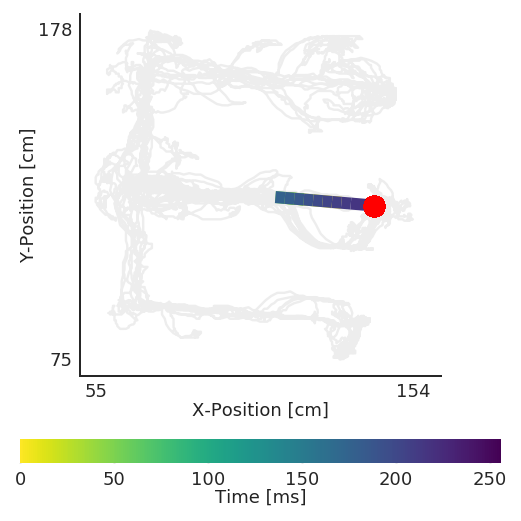

In [6]:
epoch_key = "bon", 8, 6
ripple_number = 11

plot_ripple_figure_1D(epoch_key, ripple_number)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO36.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO36.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO36.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO36.mat
No DIO file found, inferring correct inbound/outbound from task rules


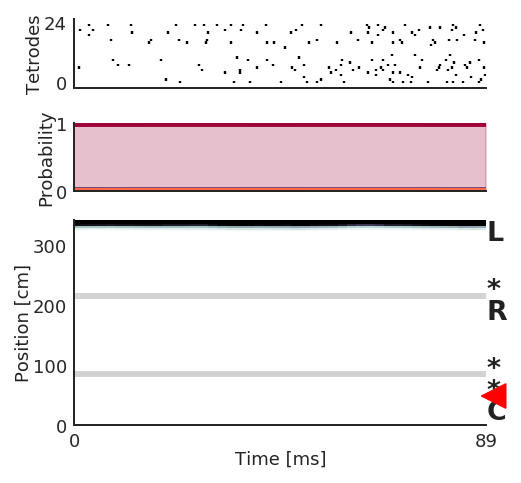

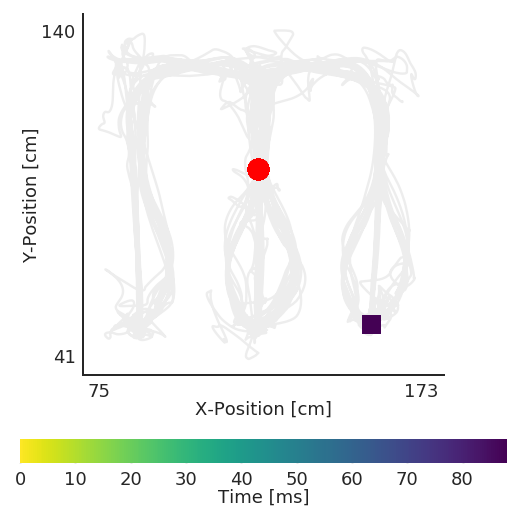

In [7]:
epoch_key = "remy", 36, 2
ripple_number = 4

plot_ripple_figure_1D(epoch_key, ripple_number)

## Population Analysis

In [60]:
from glob import glob
import os
import pandas as pd
from src.parameters import PROCESSED_DATA_DIR, STATE_COLORS, STATE_ORDER
from src.figure_utilities import TWO_COLUMN, PAGE_HEIGHT, save_figure
import seaborn as sns
import matplotlib.pyplot as plt
from src.visualization import (
    plot_category_counts,
    plot_category_duration,
    plot_linear_position_markers,
)

from loren_frank_data_processing import make_tetrode_dataframe
from src.parameters import ANIMALS, STATE_ORDER, _BRAIN_AREAS

tetrode_info = make_tetrode_dataframe(ANIMALS)

data_type, dim = "clusterless", "1D"
n_unique_spiking = 2

file_paths = glob(
    os.path.join(PROCESSED_DATA_DIR, f"*_{data_type}_{dim}_replay_info.csv")
)
replay_info = pd.concat(
    [pd.read_csv(file_path) for file_path in file_paths], axis=0,
).set_index(["animal", "day", "epoch", "ripple_number"])
replay_info = replay_info.loc[
    replay_info.n_unique_spiking >= n_unique_spiking
].sort_index()

is_brain_areas = tetrode_info.area.astype(str).str.upper().isin(_BRAIN_AREAS)
n_tetrodes = (
    tetrode_info.loc[is_brain_areas]
    .groupby(["animal", "day", "epoch"])
    .tetrode_id.count()
    .rename("n_tetrodes")
)
replay_info = pd.merge(
    replay_info.reset_index(), pd.DataFrame(n_tetrodes).reset_index()
).set_index(["animal", "day", "epoch", "ripple_number"])

for state in STATE_ORDER:
    replay_info[f"{state}_pct_unique_spiking"] = (
        replay_info[f"{state}_n_unique_spiking"] / replay_info["n_tetrodes"]
    )
replay_info = replay_info.rename(index={"Cor": "cor"}).rename_axis(
    index={"animal": "Animal ID"}
)
replay_info.head()

Continuous  Continuous_duration  \
Animal ID day epoch ripple_number                                    
cor       1   2     1                   False                0.000   
                    2                   False                0.000   
                    3                   False                0.000   
                    4                    True                0.078   
                    5                   False                0.000   

                                   Continuous_max_probability  \
Animal ID day epoch ripple_number                               
cor       1   2     1                                0.433000   
                    2                                0.145381   
                    3                                0.253176   
                    4                                0.984090   
                    5                                0.471484   

                                   Continuous_max_time  Continuous_min_time  \
Animal ID day epoch ripple_number                                             
cor       1   2     1                              NaN                  NaN   
                    2                              NaN                  NaN   
                    3                              NaN                  NaN   
                    4                             76.0                  0.0   
                    5                              NaN                  NaN   

                                   Continuous_n_total_spikes  \
Animal ID day epoch ripple_number                              
cor       1   2     1                                    NaN   
                    2                                    NaN   
                    3                                    NaN   
                    4                                  115.0   
                    5                                    NaN   

                                   Continuous_n_unique_spiking  \
Animal ID day epoch ripple_number                                
cor       1   2     1                                      NaN   
                    2                                      NaN   
                    3                                      NaN   
                    4                                      9.0   
                    5                                      NaN   

                                   Continuous_population_rate  \
Animal ID day epoch ripple_number                               
cor       1   2     1                                     NaN   
                    2                                     NaN   
                    3                                     NaN   
                    4                             1474.358974   
                    5                                     NaN   

                                   Continuous_replay_distance_from_actual_position  \
Animal ID day epoch ripple_number                                                    
cor       1   2     1                                                          NaN   
                    2                                                          NaN   
                    3                                                          NaN   
                    4                                                    23.952425   
                    5                                                          NaN   

                                   Continuous_replay_distance_from_center_well  \
Animal ID day epoch ripple_number                                                
cor       1   2     1                                                      NaN   
                    2                                                      NaN   
                    3                                                      NaN   
                    4                                                23.952425   
                    5                                                  

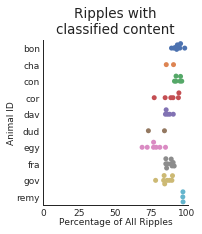

In [39]:
df = (
    replay_info.groupby(["Animal ID", "day"])
    .apply(lambda df: (df["is_classified"]).mean() * 100)
    .rename("Percentage of All Ripples")
)


sns.catplot(
    data=df.reset_index(),
    x="Percentage of All Ripples",
    y="Animal ID",
    ci="sd",
    kind="swarm",
    height=PAGE_HEIGHT / 4,
    size=3
)
plt.xlim((0, 101))
plt.title("Ripples with\nclassified content")

save_figure("figure3_ripples_with_classified_content")

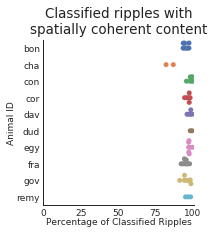

In [40]:
df = (
    replay_info.loc[replay_info.is_classified]
    .groupby(["Animal ID", "day"])
    .apply(
        lambda df: (df["Hover"] | df["Hover-Continuous-Mix"] | df["Continuous"]).mean()
        * 100
    )
    .rename("Percentage of Classified Ripples")
)
for kind in ["swarm"]:
    sns.catplot(
        data=df.reset_index(),
        x="Percentage of Classified Ripples",
        y="Animal ID",
        ci="sd",
        kind=kind,
        height=PAGE_HEIGHT / 4,
        size=3
    )
    plt.xlim((0, 101))
    plt.title("Classified ripples with\nspatially coherent content")

save_figure("figure3_classified_ripples_with_some_spatially_coherent_content")

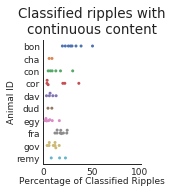

In [41]:
df = (
    replay_info.groupby(["Animal ID", "day"])
    .apply(lambda df: (df["Continuous"]).mean() * 100)
    .rename("Percentage of Classified Ripples")
)


sns.catplot(
    data=df.reset_index(),
    x="Percentage of Classified Ripples",
    y="Animal ID",
    ci="sd",
    kind="swarm",
    height=PAGE_HEIGHT / 4,
    s=3,
)
plt.xlim((0, 101))
plt.title("Classified ripples with\ncontinuous content")
save_figure("figure3_classified_ripples_with_some_continuous_content")

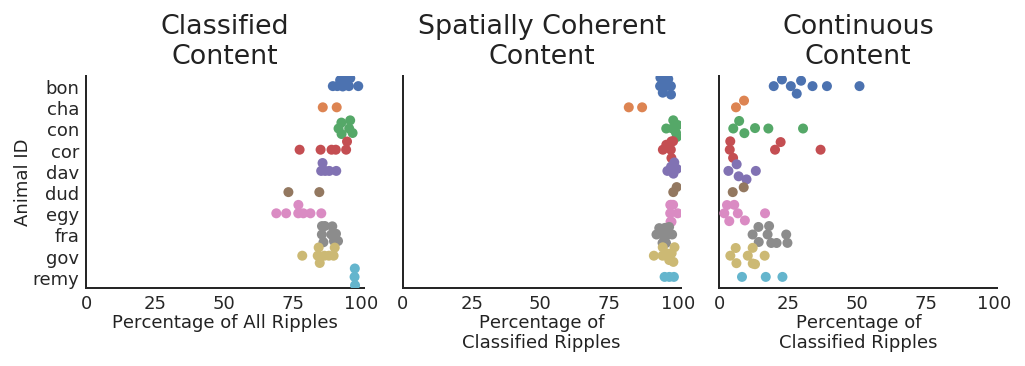

In [82]:
fig, axes = plt.subplots(
    1,
    3,
    figsize=(TWO_COLUMN, PAGE_HEIGHT / 4),
    sharex=True,
    sharey=True,
    constrained_layout=True,
)

# ax 0
df = pd.DataFrame(
    replay_info.groupby(["Animal ID", "day"])
    .apply(lambda df: (df["is_classified"]).mean() * 100)
    .rename("Percentage of All Ripples")
).reset_index()

sns.swarmplot(
    data=df, x="Percentage of All Ripples", y="Animal ID", ax=axes[0],
)
axes[0].set_title("Classified\nContent")

# ax 1
df = pd.DataFrame(
    replay_info.loc[replay_info.is_classified]
    .groupby(["Animal ID", "day"])
    .apply(
        lambda df: (df["Hover"] | df["Hover-Continuous-Mix"] | df["Continuous"]).mean()
        * 100
    )
    .rename("Percentage of Classified Ripples")
).reset_index()
sns.swarmplot(
    data=df, x="Percentage of Classified Ripples", y="Animal ID", ax=axes[1],
)
axes[1].set_ylabel("")
axes[1].set_xlabel("Percentage of\nClassified Ripples")
axes[1].set_title("Spatially Coherent\nContent")

# ax 2
df = pd.DataFrame(
    replay_info.groupby(["Animal ID", "day"])
    .apply(lambda df: (df["Continuous"]).mean() * 100)
    .rename("Percentage of Classified Ripples")
).reset_index()

sns.swarmplot(
    data=df, x="Percentage of Classified Ripples", y="Animal ID", ax=axes[2],
)
axes[2].set_xlabel("Percentage of\nClassified Ripples")
axes[2].set_ylabel("")
axes[2].set_title("Continuous\nContent")

plt.xlim((0, 101))

sns.despine()
save_figure("figure3_population_analysis")